* ambil kaggle api dari akun kaggle, save di local
* upload file tsb ke colab

In [1]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paste kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle


In [2]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle


kaggle.json


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 98% 1.15G/1.17G [00:31<00:00, 36.4MB/s]
100% 1.17G/1.17G [00:31<00:00, 40.5MB/s]


In [4]:
!unzip -q /content/labeled-chest-xray-images.zip -d images #images adalah nama folder

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [6]:
os.listdir('/content/images/chest_xray')

['test', 'train']

In [7]:
main_path = '/content/images/chest_xray'

In [8]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')

In [10]:
print('test set: \n' + '='*77)
num_pneumonia= len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')


test set: 
jumlah pneumonia= 390
jumlah normal= 234


In [11]:
print('train set: \n' + '='*77)
num_pneumonia= len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')

train set: 
jumlah pneumonia= 3883
jumlah normal= 1349


In [12]:
train_normal = glob.glob(train_dir+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_dir+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_dir+"/PNEUMONIA/*.jpeg")


In [13]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))    # ini untuk mengambil nama label, normal atau pneumonia
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_normal + train_pneumonia)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_normal + test_pneumonia)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [15]:
print(train_df.shape)
train_df.head(5)

(5232, 2)


,images,label
0,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
1,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
2,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
3,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
4,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL


In [21]:
from sklearn.model_selection import train_test_split
val_df, test_df = train_test_split(test_df, test_size=0.05, random_state=1, stratify=test_df['label'])
print(test_df.shape)
print(val_df.shape)

(32, 2)
(592, 2)


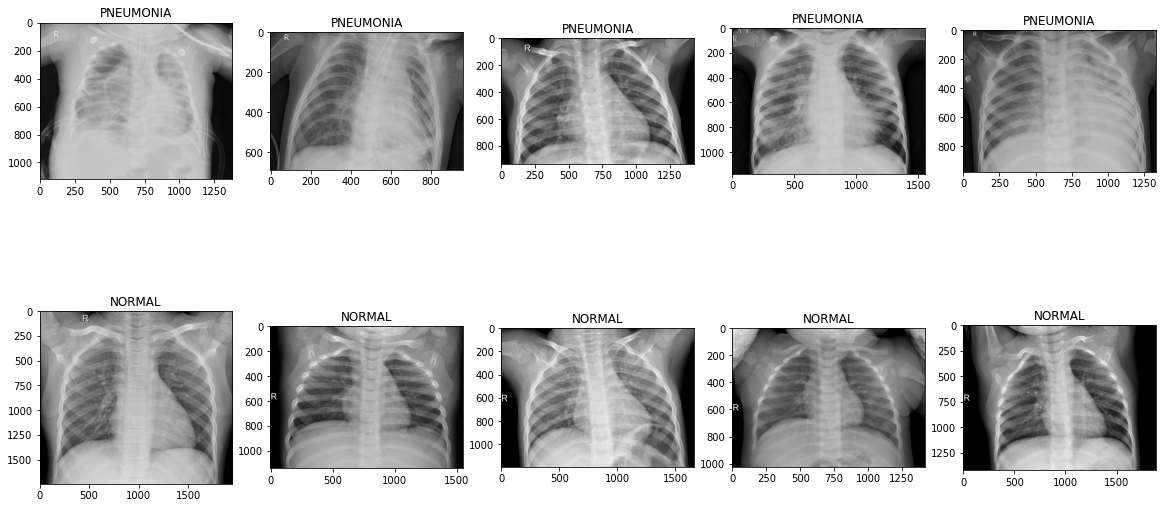

In [22]:
pneumonia_samples = (train_df[train_df['label']=="PNEUMONIA"]['images'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']=='NORMAL']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(pneumonia_samples + normal_samples)


Ternyata tiap gambar tidak memiliki size yang sama

In [23]:
img_height = 220
img_width = 220
SEED = 1
BATCH = 32

# agar output notebook stabil
np.random.seed(42)
tf.random.set_seed(42)

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

tujuan augmentasi, biar mengenal pola yang berbeda-beda sekaligus merubah-rubah image

In [24]:
# Augmentasi data
train_datagen = ImageDataGenerator(
                rescale = 1./255,     # normalisasi data
                rotation_range = 0.1,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [25]:
ds_train = train_datagen.flow_from_dataframe(          # alternative to this is flow_from_directory
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED)

Found 5232 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.


In [28]:
# untuk cek mapping dari class yang ada (berguna terutama untuk multiclass)
ds_train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [38]:
# callbacks
callbacks_a = [
               EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1),
               ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
               # ReduceLROnPlateau
]

In [33]:
input = [img_height, img_width, 3]

model_1 = Sequential()

# Conv 1
model_1.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input)) # kernel_initializer bisa diatur di sini
model_1.add(MaxPooling2D(pool_size=2, strides=2))  # bisa atur padding di sini dengan padding = same
# dropout atau batch normalization bisa ditambah di sini

# Conv 2
model_1.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Flatten())

# Fully connected layers
model_1.add(Dense(units=128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

In [34]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 89888)             0         
                                                                 
 dense (Dense)               (None, 128)              

In [35]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
history = model_1.fit(ds_train, batch_size=BATCH, epochs=10, validation_data=ds_val, callbacks= callbacks_a, verbose=1)

Epoch 1/10
164/164 [==============================] - 99s 605ms/step - loss: 0.2842 - accuracy: 0.8769 - val_loss: 0.3226 - val_accuracy: 0.8446
Epoch 2/10
164/164 [==============================] - 105s 640ms/step - loss: 0.2673 - accuracy: 0.8874 - val_loss: 0.3219 - val_accuracy: 0.8345
Epoch 3/10
164/164 [==============================] - 100s 609ms/step - loss: 0.2527 - accuracy: 0.8926 - val_loss: 0.2817 - val_accuracy: 0.8682
Epoch 4/10
164/164 [==============================] - 100s 607ms/step - loss: 0.2276 - accuracy: 0.9044 - val_loss: 0.4009 - val_accuracy: 0.8125
Epoch 5/10
164/164 [==============================] - 112s 681ms/step - loss: 0.2228 - accuracy: 0.9027 - val_loss: 0.2361 - val_accuracy: 0.8986
Epoch 6/10
164/164 [==============================] - 98s 596ms/step - loss: 0.2040 - accuracy: 0.9138 - val_loss: 0.2506 - val_accuracy: 0.8919
Epoch 7/10
164/164 [==============================] - 98s 596ms/step - loss: 0.2078 - accuracy: 0.9121 - val_loss: 0.3422 - va

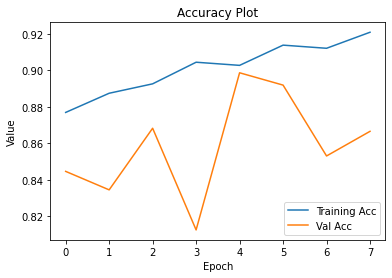

In [40]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

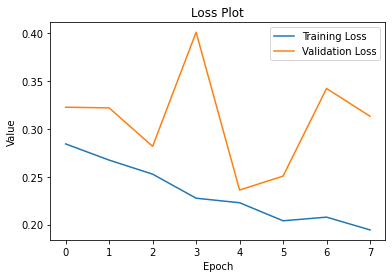

In [41]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [42]:
!nvidia-smi

Mon May 23 08:33:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |   1816MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Testing

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(220,220)) #inget mesti sesuai input yg sebelumnya
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 1:
    print('pneumonia')
  else:
    print('normal')